# Normalizing Flows
In this tutorial, we will implement normalizing flows using the Dr.Jit
compiler.

## Imports

In [1]:
from pathlib import Path
import imageio.v3 as iio
import tqdm
import matplotlib.pyplot as plt
import numpy as np

import drjit as dr
import drjit.nn as nn
from drjit.opt import Adam, GradScaler
from drjit.auto.ad import (
    Texture2f,
    TensorXf,
    TensorXf16,
    Float16,
    Float32,
    ArrayXf16,
    Array2f,
    Array3f,
)

First we initialize a random number generator, which will be used as the
source of randomness in this tutorial, ensuring that variables remain
uncorrelated.

In [2]:

rng = dr.rng(seed=0)

We use a standard normal distribution for the base distribution of the flow
model. Since our random number generator produces uniformly distributed
values, we define this function to warp them into gaussian distributed
values. The flow model also requires us to evaluate the logarithm of this
distribution, and we therefore also define this function.

In [3]:


def square_to_std_normal(sample: Array2f):
    """
    This function takes a sample from a uniform square distribution, and
    transforms it into a sample from a standard normal distribution.
    """
    r = dr.sqrt(-2.0 * dr.log(1.0 - sample[0]))
    phi = 2.0 * dr.pi * sample[1]

    s, c = dr.sincos(phi)
    return Array2f(c * r, s * r)


def log_std_normal_pdf(z: dr.ArrayBase):
    return dr.log(dr.inv_two_pi) - 0.5 * dr.square(z)

## Reference Distribution
To train a flow model, we have to sample values from a reference distribution
$\widehat{p_X}$. In this example, we sample from a double spiral.
We first define a `Distr2D` interface, representing a sampleable distribution.
It has a function `sample`, which takes a random number generator and the
number of samples to be generated, and returns 2d coordinates.

In [4]:


class Distr2D:
    def sample(
        self,
        rng: dr.random.Generator,
        n: int,
    ) -> Array2f: ...


class SpiralDistr(Distr2D):
    """
    This distrubution generates samples according to a spiral patern.
    """

    def __init__(self) -> None: ...
    def sample(
        self,
        rng: dr.random.Generator,
        n: int,
    ) -> Array2f:
        sample1 = rng.random(Float32, n)
        sample2 = rng.random(Array2f, (2, n))

        sample1 = sample1 * 2 - 1
        t = dr.sqrt(dr.abs(sample1))
        r = t * 4 * dr.sign(sample1)
        phi = t * dr.two_pi * 1.5

        s, c = dr.sincos(phi)
        x = Array2f(c * r, s * r)
        y = square_to_std_normal(sample2) * 0.15

        return x + y

It is also possible to sample values according to an arbitrary distribution,
which we can define using an image. To use this distribution, Mitsuba~3 has
to be installed, which provides an implementation of a fast discrete
distribution.

In [5]:


class ImageDistr(Distr2D):
    """
    This distrubtion generates samples, according to the probability density
    function represented by an image.
    """

    def __init__(
        self,
        uri: str = "data/albert.jpg",
    ) -> None:
        import mitsuba as mi

        mi.set_variant("cuda_ad_rgb", "llvm_ad_rgb")

        self.mi = mi

        img = iio.imread(uri)
        if len(img.shape) == 3:
            img = img.mean(-1)
        img = img / img.sum(None)
        self.shape = img.shape

        distr = mi.DiscreteDistribution2D(img)
        self.distr = distr

    def sample(
        self,
        rng: dr.random.Generator,
        n: int,
    ) -> Array2f:
        """
        This function samples points, according to their probability density,
        represented by the image. We scale the distrubtuion to fit neatly into
        the [-4, 4]^2 range.
        """
        mi = self.mi
        x, _, _ = self.distr.sample(rng.random(mi.Point2f, (2, n)))
        m = max(self.shape[0], self.shape[1])
        x = mi.Point2f(x) / mi.Vector2f(m)
        x = mi.Point2f(x.x, 1.0 - x.y)
        return Array2f(x * 8 - 4)


# To use the image distribution, uncomment the second line.
ref = SpiralDistr()
# ref = ImageDistr()

To visualize the distribution, we define a function, which plots the
histograms of samples from said distribution.

Text(0.5, 1.0, 'sampled')

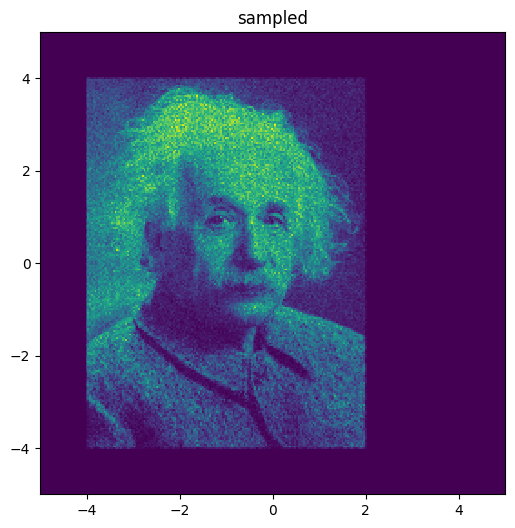

In [6]:


def plot_hist(*distrs: tuple[str, Distr2D]):
    """
    Plots the histograms of distributions with their names
    """
    n = len(distrs)
    n_bins = 256
    hist_range = [[-5, 5], [-5, 5]]
    fig, ax = plt.subplots(1, n, figsize=(6 * n, 6))
    ax = [ax] if n == 1 else ax
    for i in range(n):
        name, dist = distrs[i]
        x = dist.sample(rng, 1_000_000)
        ax[i].hist2d(x[0], x[1], bins=n_bins, range=hist_range)
        ax[i].set_title(name)


plot_hist(("Reference", ref))

Normalizing flows can be used to both sample from a learned distribution, but
also evaluate the probability density function for a given sample. This makes
them very useful in computer graphics, where both properties are often
required.

A normalizing flow is represented by an invertible function $f_\theta$. To
sample random variables $X$ from the learned distribution, we sample latent
variables $Z$ from a normal gaussian distribution $Z \sim p_Z = N(0, 1)$, and
apply the inverse flow $X = f^{-1}_\theta(Z)$.

We parameterize the normalizing flows with coupling and permutation layers
$f_{i;\theta}$, such that $X = f_{0;\theta} \circ f_{1;\theta} \circ \dots
f_{D;\theta} (Z)$. To train the network, we maximize the log sum of the
estimated probability of sampling the sample i.e. $max \sum \text{log}
p_{X;\theta}(X_i)$. To compute this probability, we can sum over the log
determinant of the layers, $p_{X;\theta}(X) = \text{log} \left\vert \text{det} {\partial z
\over \partial x} \right\vert_{\theta} + \text{log} p_{Z}(Z)$.

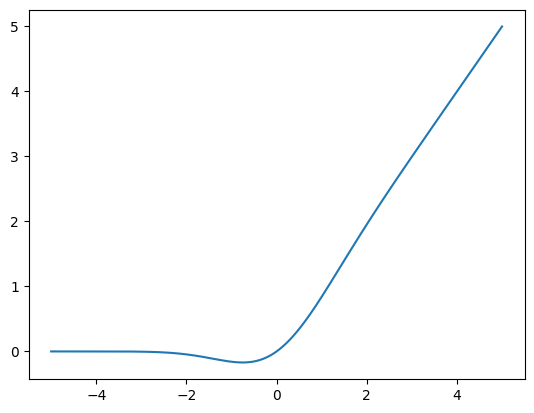

In [7]:


class GELU(nn.Module):
    r""" """

    DRJIT_STRUCT = {}

    def __call__(self, arg: nn.CoopVec, /) -> nn.CoopVec:
        return (
            0.5
            * arg
            * (1 + dr.tanh(dr.sqrt(2 / dr.pi) * (arg + 0.044715 * arg * arg * arg)))
        )


x = dr.linspace(Float32, -5, 5, 1000)
y = GELU()(x)
plt.plot(x, y)

In [8]:


class TwoAlign(nn.Module):
    r""" """

    DRJIT_STRUCT = {}

    def _alloc(
        self, dtype: type[dr.ArrayBase], size: int, rng: dr.random.Generator, /
    ) -> tuple[nn.Module, int]:
        return self, size if size % 2 == 0 else size + 1

    def __call__(self, arg: nn.CoopVec, /) -> nn.CoopVec:
        tp = arg.type
        arg = list(arg)
        if len(arg) % 2 != 0:
            arg.append(tp(0))
        return nn.CoopVec(*arg)

In [9]:


class FlowLayer(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def inverse(self, z: nn.CoopVec) -> nn.CoopVec: ...
    def forward(self, x: nn.CoopVec) -> tuple[nn.CoopVec, Float16]: ...


class PermutationLayer(FlowLayer):
    def __init__(self) -> None:
        super().__init__()

    def inverse(self, z: nn.CoopVec) -> nn.CoopVec:
        z = list(z)
        z.reverse()
        x = nn.CoopVec(z)
        return x

    def forward(self, x: nn.CoopVec) -> tuple[nn.CoopVec, Float16]:
        x = list(x)
        x.reverse()
        z = nn.CoopVec(x)
        ldj = Float16(0)
        return z, ldj


class CouplingLayer(FlowLayer):

    DRJIT_STRUCT = {
        "net": nn.Sequential,
        "config": tuple,
    }

    def __init__(
        self, n_hidden: int = 1, width: int = 2, n_activations: int = 32
    ) -> None:
        super().__init__()

        self.config = (width,)

        sequential = []
        # sequential.append(nn.TriEncode(16, 0))
        sequential.append(TwoAlign())
        sequential.append(nn.Linear(-1, n_activations))
        sequential.append(nn.ReLU())
        for i in range(n_hidden):
            sequential.append(nn.Linear(n_activations, n_activations))
            sequential.append(nn.ReLU())
        sequential.append(nn.Linear(n_activations, width))

        self.net = nn.Sequential(*sequential)

    def inverse(self, z: nn.CoopVec) -> nn.CoopVec:
        r"""
        This function represents the inverse evaluation of the coupling layer,
        i.e. $X = f^{-1}_\theta(Z)$.
        """
        z: list = ArrayXf16(z)
        d = len(z) // 2
        id, z2 = z[:d, :], z[d:, :]
        p = ArrayXf16(self.net(nn.CoopVec(id)))
        log_s, b = p[:d, :], p[d:, :]
        x2 = (z2 - b) * dr.exp(-log_s)
        x = nn.CoopVec(id, x2)
        return x

    def forward(self, x: nn.CoopVec) -> tuple[nn.CoopVec, Float16]:
        r"""
        This function evaluates the foward flow $Z = f_\theta(X)$, as well as
        the log jacobian determinant.
        """
        x = ArrayXf16(x)
        d = len(x) // 2
        id, x2 = x[:d, :], x[d:, :]
        p = ArrayXf16(self.net(nn.CoopVec(id)))
        log_s, b = p[:d, :], p[d:, :]
        z2 = x2 * dr.exp(log_s) + b
        z = nn.CoopVec(id, z2)
        ldj = dr.sum(log_s)
        return z, ldj

    def _alloc(
        self, dtype: type[dr.ArrayBase], size: int, rng: dr.random.Generator, /
    ) -> tuple[nn.Module, int]:

        (width,) = self.config
        if width < 0:
            width = size

        net, _ = self.net._alloc(dtype, width // 2, rng)

        result = CouplingLayer()
        result.net = net

        return result, size


class Flow(nn.Module):

    DRJIT_STRUCT = {
        "layers": list[FlowLayer],
    }

    def __init__(self, *args: FlowLayer) -> None:
        super().__init__()
        self.layers = args

    def sample_base_dist(self, sample: nn.CoopVec) -> nn.CoopVec:
        sample = list(sample)
        z = []
        for i in range(0, len(sample), 2):
            x, y = square_to_std_normal(Array2f(sample[i], sample[i + 1]))
            z.append(Float16(x))
            z.append(Float16(y))

        return nn.CoopVec(*z)

    def eval_log_base_dist(self, z: nn.CoopVec) -> dr.ArrayBase:
        return dr.sum([log_std_normal_pdf(z) for z in z])

    def log_eval(self, x: nn.CoopVec) -> Float16:
        """
        This function calculates the log probability of sampling a given value
        `x`.
        """

        log_p = dr.zeros(x.type)

        for layer in self.layers:
            x, ldj = layer.forward(x)
            log_p += Float32(ldj)

        log_p += self.eval_log_base_dist(x)
        return log_p

    def sample(self, sample: nn.CoopVec) -> nn.CoopVec:
        r"""
        Sample a function from the learned target distribution $X \sim
        p_{X;\theta}$, given a sample from the uniform distribution.
        """
        z = self.sample_base_dist(sample)

        for layer in reversed(self.layers):
            z = layer.inverse(z)

        return z

    def _alloc(
        self, dtype: type[dr.ArrayBase], size: int, rng: dr.random.Generator, /
    ) -> tuple[nn.Module, int]:

        layers = []
        for l in self.layers:
            l_new, size = l._alloc(dtype, size, rng)
            layers.append(l_new)

        result = Flow(*layers)
        return result, size


class FlowDistr(Distr2D):
    """
    Wrapper class arround a normalizing flow, to sample from it's distribution
    using a random number generator.
    """

    def __init__(self, flow) -> None:
        self.flow = flow

    def sample(self, rng: dr.random.Generator, n: int) -> Array2f:
        x = ArrayXf16(flow.sample(nn.CoopVec(rng.random(ArrayXf16, (2, n)))))
        return x

In [10]:

layers = [
    *[CouplingLayer(), PermutationLayer()] * 4,
    # CouplingLayer(),
    # PermutationLayer(),
    # CouplingLayer(),
]
flow: Flow = Flow(*layers)

flow = flow.alloc(TensorXf16, rng=rng)

weights, flow = nn.pack(flow, "training")

Text(0.5, 1.0, 'flow')

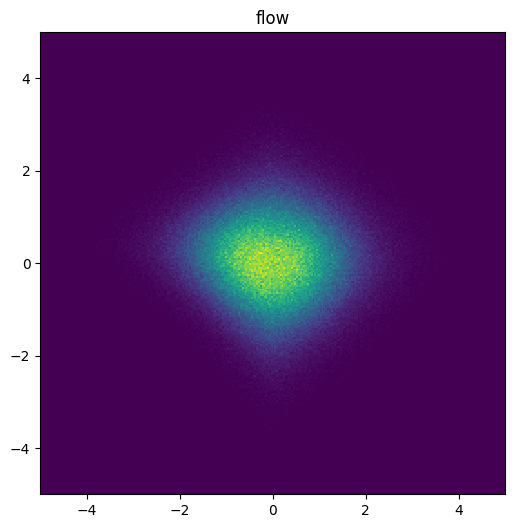

In [11]:
plot_hist(("Initial", FlowDistr(flow)), ("Reference", ref))

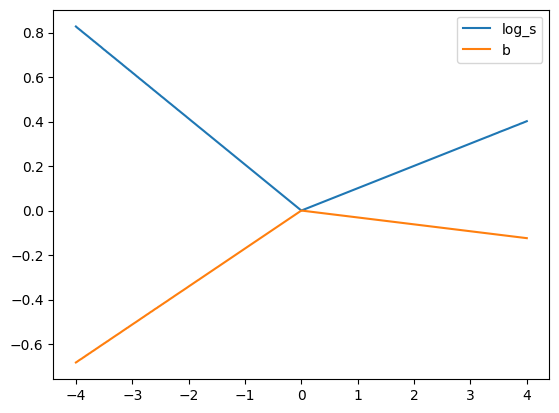

In [12]:
x = dr.linspace(Float16, -4, 4, 1_000)
n = list(flow.layers[0].net(nn.CoopVec(x)))
plt.plot(x, n[0], label="log_s")
plt.plot(x, n[1], label="b")
plt.legend()

In [13]:

opt = Adam(lr=0.001, params={"weights": Float32(weights)})

scaler = GradScaler()

batch_size = 2**14
n = 10_000
its = []
losses = []

iterator = tqdm.tqdm(range(n))
for it in iterator:
    weights[:] = Float16(opt["weights"])

    x = ref.sample(rng, n)
    x = nn.CoopVec(ArrayXf16(x))

    log_p = flow.log_eval(x)
    log_p[dr.isnan(log_p)] = 0
    log_p[dr.isinf(log_p)] = 0
    loss_kl = -dr.mean(log_p)

    dr.backward(scaler.scale(loss_kl))
    scaler.step(opt)

    if (it + 1) % 10 == 0:
        loss = loss_kl.numpy().item()
        losses.append(loss)
        its.append(it)
        iterator.set_postfix({"loss_kl": loss})

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:17<00:00, 556.09it/s, loss_kl=5.58]


Text(0.5, 0, 'it')

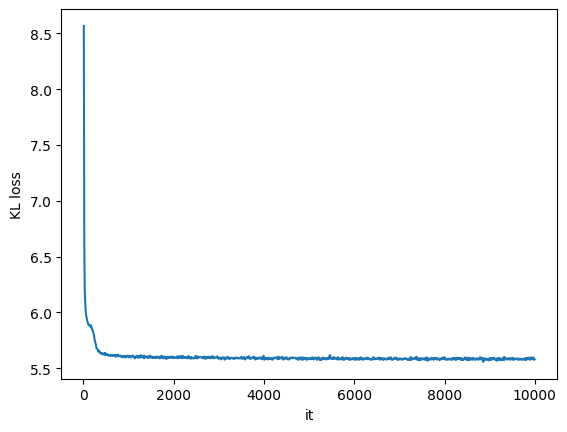

In [14]:
plt.plot(its, losses)
plt.ylabel("KL loss")
plt.xlabel("it")

Text(0.5, 1.0, 'flow')

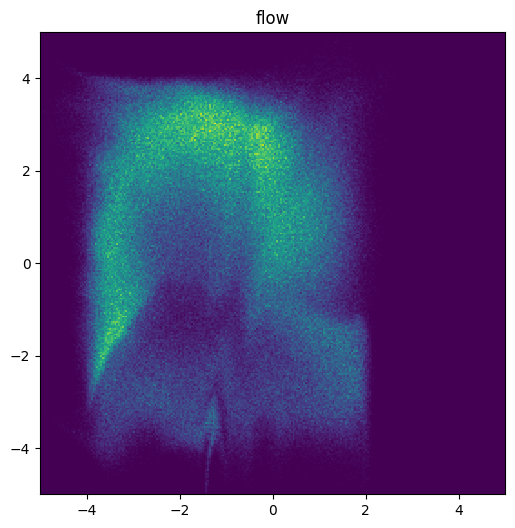

In [15]:
plot_hist(("Learned", FlowDistr(flow)), ("Reference", ref))

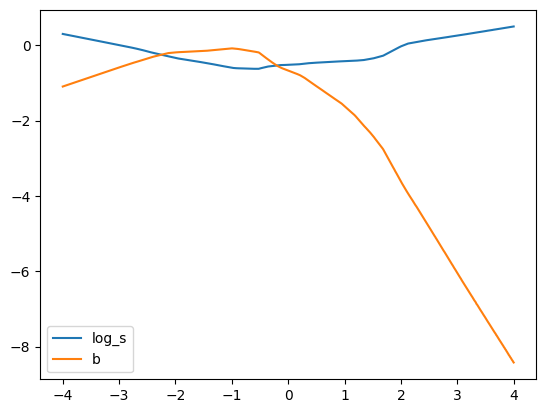

In [16]:
x = dr.linspace(Float16, -4, 4, 1_000)
n = list(flow.layers[0].net(nn.CoopVec(x)))
plt.plot(x, n[0], label="log_s")
plt.plot(x, n[1], label="b")
plt.legend()

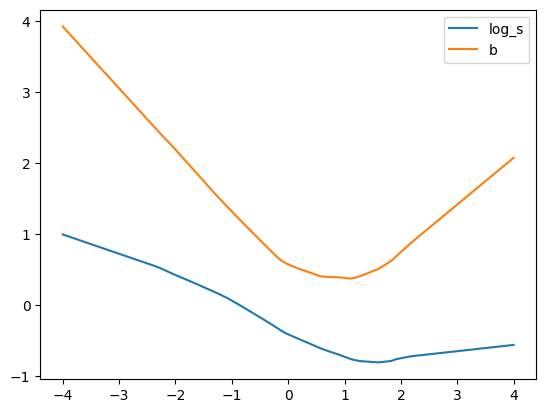

In [17]:
x = dr.linspace(Float16, -4, 4, 1_000)
n = list(flow.layers[2].net(nn.CoopVec(x)))
plt.plot(x, n[0], label="log_s")
plt.plot(x, n[1], label="b")
plt.legend()